In [201]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
import nltk
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score
import re
from collections import OrderedDict
from gensim.models import KeyedVectors
from gensim.matutils import unitvec
from whatlies import EmbeddingSet, Embedding
from whatlies.transformers import Normalizer, Tsne
from sklearn.manifold import TSNE
import pickle
import collections
from sklearn.metrics.pairwise import cosine_similarity
from nltk.corpus import stopwords

In [127]:
# Import dataset
characters_df = pd.read_csv("./dataset/Characters.csv", sep=";")
movie1_df = pd.read_csv("./dataset/Harry Potter 1.csv", sep=";")
movie2_df = pd.read_csv("./dataset/Harry Potter 2.csv", sep=";")
movie3_df = pd.read_csv("./dataset/Harry Potter 3.csv", sep=";")
potions_df = pd.read_csv("./dataset/Potions.csv", sep=";")
other_characters_df = pd.read_csv("./dataset/shortversioncharacters.csv", sep=",")
spells_df = pd.read_csv("./dataset/Spells.csv", sep=";")

In [3]:
# Analyze characters
class Character():
    def __init__(self, df):
        self.data = df
        f = open("./resources/character_mapping.json", "r")
        self.character_mapping = json.load(f)
        f.close()
        
    def map(self, character_name):
        # Map similar character to a group
        if character_name in self.character_mapping and self.character_mapping[character_name] is not None:
            return self.character_mapping[character_name].title()
        else:
            return character_name.title()

In [4]:
# Movie
movie1_df['Movie'] = 'Harry Potter and the Sorcerers Stone'
movie2_df['Movie'] = 'Harry Potter and the Chamber of Secrets'
movie3_df['Movie'] = 'Harry Potter and the Prisoner of Azkaban'

movies_list = [movie1_df, movie2_df, movie3_df]

class Movie():
    def __init__(self, df: list):
        self.movie_list = df
        self.movies_df = self.combine_movies()

    def combine_movies(self):
        # Combine movies
        for i in self.movie_list:
            i.columns = map(str.title, i.columns)
        
        return pd.concat([movie1_df, movie2_df, movie3_df], ignore_index=False)
        
    def preprocess(self):
        # Strip the spaces in character to remove identifying the same character twice
        self.movies_df["Character"] = self.movies_df.apply(lambda row: row["Character"].strip().title(), axis=1)


In [5]:
# Preprocess
def preprocessing():
    c = Character(characters_df)
    
    m = Movie(movies_list)
    m.preprocess()
    
    for i, j in m.movies_df.iterrows():
        j["Character"] = c.map(j["Character"])

    return c,m

c, m = preprocessing()

In [6]:
grouped = m.movies_df.groupby("Character").count().reset_index()
grouped.sort_values('Sentence', ascending=False)

,Character,Sentence,Movie
41,Harry,1028,1028
78,Ron,536,536
44,Hermione,485,485
40,Hagrid,394,394
21,Dumbledore,239,239
...,...,...,...
86,Slytherins,1,1
13,Cornish Pixies,1,1
69,Parvati,1,1
70,Penelope Clearwater,1,1


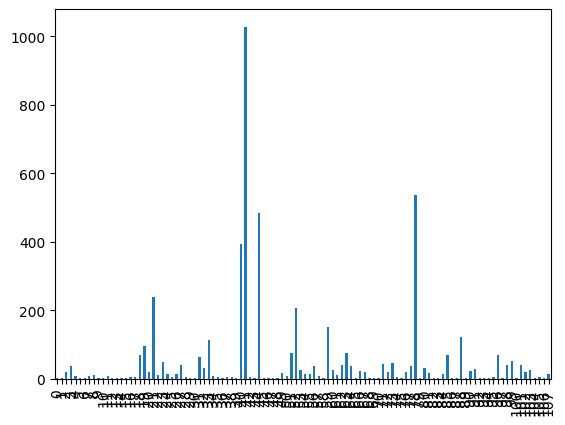

In [7]:
# create histograms for length of total script
def plotLengethOfTotalScript(df):
    # grouped.plot(kind='bar')
    pd.Series(grouped["Sentence"]).plot(kind='bar')

plotLengethOfTotalScript(m.movies_df)

In [8]:
# Combine sentences for each character
combined_sentences = m.movies_df.groupby('Character')['Sentence'].apply(' '.join).reset_index()

#Add columns for Vocabulary, vocabulary size, unique words (mentioned one time) ans most frequent words
combined_sentences['vocabulary'] = None
combined_sentences['vocabulary_size'] = None
combined_sentences['words_mentioned_once'] = None
combined_sentences['most_frequent_words'] = None

In [202]:
def PreProcessToCombinedSentences(words):
    StopWords=stopwords.words('english')
    words = [word for word in words if word not in StopWords]
    
    return words

In [203]:
def generate_Vocabulary_UniqueWords_WordsFrequency(combined_sentences) :

    for index, row in combined_sentences.iterrows():
        character = row['Character']
        sentences = row['Sentence']

        # sentences = PreProcessToRemoveDelimetersAndNumbers(sentences)
        # Tokenize the text into words
        words = nltk.word_tokenize(sentences)  
        words = [word.lower() for word in words if word.isalpha()]
        
        # Create a vocabulary (set of unique words)
        vocabulary = set(words)
    
        # Convert the set back to a sorted list if needed
        vocabulary_list = sorted(list(vocabulary))
    
        combined_sentences.at[index, 'vocabulary']=vocabulary_list
    
        # Calculate vocabulary size (total unique words)
        vocabulary_size = len(set(vocabulary))
    
        # row['vocabulary_size']==vocabulary_size
        combined_sentences.at[index, 'vocabulary_size'] = vocabulary_size
        
        words = PreProcessToCombinedSentences(words)
    
        # Create a word frequency dictionary
        word_frequency = Counter(words)
    
        # Find words mentioned only once
        words_mentioned_once = [word for word, freq in word_frequency.items() if freq == 1]
        combined_sentences.at[index, 'words_mentioned_once']=words_mentioned_once
    
        # Find the thirty most frequent words
        most_frequent_words_list = word_frequency.most_common(30)
        # Extract the words from the list of tuples
        most_frequent_words = [word for word, count in most_frequent_words_list]
        combined_sentences.at[index, 'most_frequent_words']=most_frequent_words


In [204]:
generate_Vocabulary_UniqueWords_WordsFrequency(combined_sentences)

In [205]:
#Display the result
print(combined_sentences['vocabulary'])

0                                        [ahhhhhhh, yay]
1                [about, know, sorcerer, stone, the, we]
2      [a, above, accused, all, an, ancient, and, any...
3      [a, about, actually, all, an, and, are, at, ba...
4      [arrive, did, door, for, graciously, harry, he...
                             ...                        
103    [a, again, all, and, another, arrrhhhhhh, ask,...
104                                      [harry, potter]
105    [are, at, back, believe, ca, come, crockford, ...
106                 [anything, dears, off, the, trolley]
107    [a, all, and, believe, booked, ca, cancel, cha...
Name: vocabulary, Length: 108, dtype: object


In [206]:
print(combined_sentences['vocabulary_size'])

0        2
1        6
2       83
3      118
4       32
      ... 
103     97
104      2
105     30
106      5
107     71
Name: vocabulary_size, Length: 108, dtype: object


In [207]:
print(combined_sentences['words_mentioned_once'])

0                                        [ahhhhhhh, yay]
1                                [know, sorcerer, stone]
2      [yes, sent, men, hollow, lie, opened, chamber,...
3      [still, ungrateful, way, damn, brother, keep, ...
4      [pupkins, masons, arrive, lounge, waiting, wel...
                             ...                        
103    [use, boy, let, speak, strength, potter, meet,...
104                                      [harry, potter]
105    [doris, crockford, mr, potter, ca, believe, me...
106                           [anything, trolley, dears]
107    [spent, summer, devising, whole, program, gon,...
Name: words_mentioned_once, Length: 108, dtype: object


In [208]:
print(combined_sentences['most_frequent_words'])

0                                        [ahhhhhhh, yay]
1                                [know, sorcerer, stone]
2      [hagrid, never, castle, yes, sent, men, hollow...
3      [boy, vernon, little, petunia, something, say,...
4      [harry, oh, pupkins, masons, arrive, lounge, w...
                             ...                        
103    [harry, see, something, lies, enough, live, gi...
104                                      [harry, potter]
105    [doris, crockford, mr, potter, ca, believe, me...
106                           [anything, trolley, dears]
107    [new, quidditch, train, today, professor, seek...
Name: most_frequent_words, Length: 108, dtype: object


In [210]:
combined_sentences.sort_values('vocabulary_size', ascending=False).head(50)

,Character,Sentence,vocabulary,vocabulary_size,words_mentioned_once,most_frequent_words
41,Harry,"Yes, Aunt Petunia. Yes, Uncle Vernon. He's asl...","[a, about, accepted, accidentally, according, ...",970,"[aunt, petunia, watching, press, ugly, often, ...","[ron, hagrid, come, know, go, get, think, herm..."
44,Hermione,Has anyone seen a toad? A boy named Neville's ...,"[a, able, about, accident, according, add, aft...",751,"[toad, named, magic, spell, tried, ones, examp...","[harry, ron, go, come, one, ca, got, going, co..."
78,Ron,Excuse me. Do you mind? Everywhere else is ful...,"[a, aaa, aboard, about, across, actually, afte...",749,"[excuse, everywhere, full, set, every, flavor,...","[harry, go, think, got, know, hermione, one, r..."
21,Dumbledore,"I should've known that you would be here, Prof...","[a, abilities, able, about, account, across, a...",703,"[bad, bringing, problems, albus, leaving, peop...","[harry, professor, well, would, hagrid, points..."
40,Hagrid,"Professor Dumbledore, sir. Professor McGonagal...","[a, about, absolutely, according, acne, across...",675,"[mcgonagall, tyke, fell, asleep, flying, brist...","[harry, well, come, go, right, dumbledore, pro..."
52,Lupin,"Here, eat this. It'll help. It's all right. It...","[a, about, absolutely, actually, advanced, aff...",496,"[help, chocolate, guards, azkaban, gone, searc...","[harry, well, good, yes, much, see, come, memo..."
59,Mcgonagall,"Good evening, Professor Dumbledore. Are the ru...","[a, able, about, according, actions, admitted,...",464,"[rumors, wise, hagrid, important, watched, sor...","[potter, weasley, slytherin, school, professor..."
88,Snape,There will be no foolish wand-waving or silly ...,"[a, abilities, about, aconite, added, after, a...",430,"[foolish, incantations, class, expect, many, a...","[potter, one, werewolf, would, well, turn, tim..."
33,Gilderoy Lockhart,Let me introduce you to your new Defense Again...,"[a, about, accidents, adventure, afraid, again...",362,"[new, arts, teacher, gilderoy, lockhart, order...","[harry, well, professor, let, know, see, round..."
96,Tom Riddle,"Professor Dumbledore. Yes, professor. I suppos...","[a, able, about, afraid, after, again, against...",295,"[suppose, rumors, true, well, home, really, st...","[hagrid, would, ginny, dumbledore, wo, knew, v..."


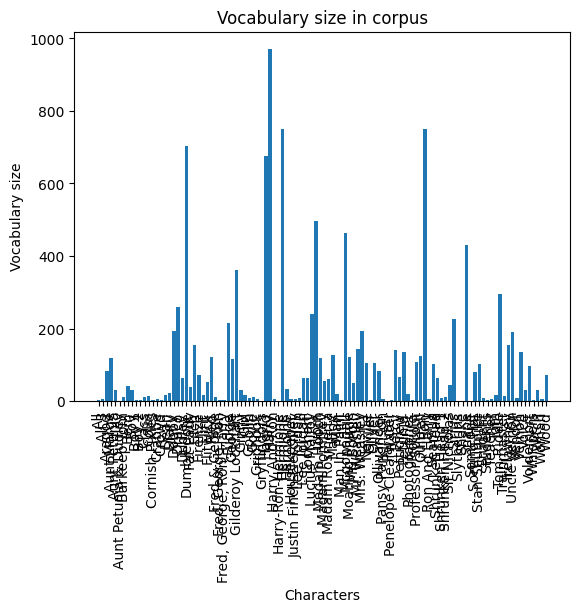

<Figure size 3000x2300 with 0 Axes>

In [211]:
# create histograms for vocabulary size of characters
def plotVocabularySizeOfCharacters(df):
    # pd.Series(df['vocabulary_size']).plot(kind='bar')
    plt.bar(df['Character'].tolist(), df['vocabulary_size'].tolist())
    plt.title("Vocabulary size in corpus")
    plt.ylabel("Vocabulary size")
    plt.xlabel("Characters")
    plt.xticks(rotation='vertical')
    plt.figure(figsize=(30, 23))
    plt.show()

plotVocabularySizeOfCharacters(combined_sentences)

In [212]:
combined_sentences_50_most_vocabulary=combined_sentences.sort_values('vocabulary_size', ascending=False).reset_index().head(50)

In [213]:
combined_sentences_50_most_vocabulary

,index,Character,Sentence,vocabulary,vocabulary_size,words_mentioned_once,most_frequent_words
0,41,Harry,"Yes, Aunt Petunia. Yes, Uncle Vernon. He's asl...","[a, about, accepted, accidentally, according, ...",970,"[aunt, petunia, watching, press, ugly, often, ...","[ron, hagrid, come, know, go, get, think, herm..."
1,44,Hermione,Has anyone seen a toad? A boy named Neville's ...,"[a, able, about, accident, according, add, aft...",751,"[toad, named, magic, spell, tried, ones, examp...","[harry, ron, go, come, one, ca, got, going, co..."
2,78,Ron,Excuse me. Do you mind? Everywhere else is ful...,"[a, aaa, aboard, about, across, actually, afte...",749,"[excuse, everywhere, full, set, every, flavor,...","[harry, go, think, got, know, hermione, one, r..."
3,21,Dumbledore,"I should've known that you would be here, Prof...","[a, abilities, able, about, account, across, a...",703,"[bad, bringing, problems, albus, leaving, peop...","[harry, professor, well, would, hagrid, points..."
4,40,Hagrid,"Professor Dumbledore, sir. Professor McGonagal...","[a, about, absolutely, according, acne, across...",675,"[mcgonagall, tyke, fell, asleep, flying, brist...","[harry, well, come, go, right, dumbledore, pro..."
5,52,Lupin,"Here, eat this. It'll help. It's all right. It...","[a, about, absolutely, actually, advanced, aff...",496,"[help, chocolate, guards, azkaban, gone, searc...","[harry, well, good, yes, much, see, come, memo..."
6,59,Mcgonagall,"Good evening, Professor Dumbledore. Are the ru...","[a, able, about, according, actions, admitted,...",464,"[rumors, wise, hagrid, important, watched, sor...","[potter, weasley, slytherin, school, professor..."
7,88,Snape,There will be no foolish wand-waving or silly ...,"[a, abilities, about, aconite, added, after, a...",430,"[foolish, incantations, class, expect, many, a...","[potter, one, werewolf, would, well, turn, tim..."
8,33,Gilderoy Lockhart,Let me introduce you to your new Defense Again...,"[a, about, accidents, adventure, afraid, again...",362,"[new, arts, teacher, gilderoy, lockhart, order...","[harry, well, professor, let, know, see, round..."
9,96,Tom Riddle,"Professor Dumbledore. Yes, professor. I suppos...","[a, able, about, afraid, after, again, against...",295,"[suppose, rumors, true, well, home, really, st...","[hagrid, would, ginny, dumbledore, wo, knew, v..."


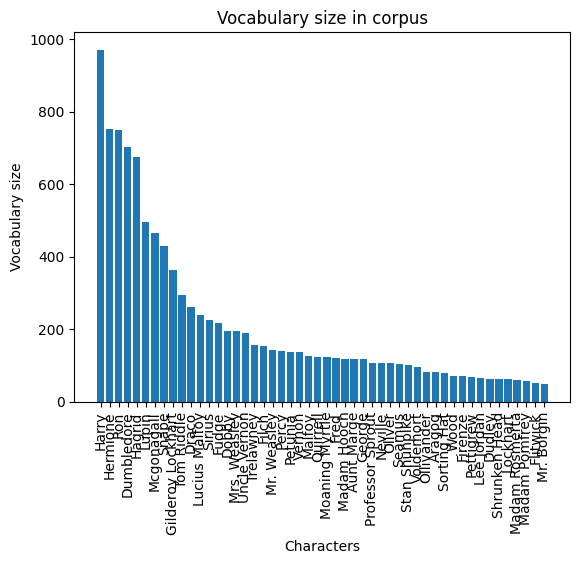

<Figure size 3000x2300 with 0 Axes>

In [214]:
plotVocabularySizeOfCharacters(combined_sentences_50_most_vocabulary)

In [215]:
combined_sentences_50_most_vocabulary['most_frequent_words']

0     [ron, hagrid, come, know, go, get, think, herm...
1     [harry, ron, go, come, one, ca, got, going, co...
2     [harry, go, think, got, know, hermione, one, r...
3     [harry, professor, well, would, hagrid, points...
4     [harry, well, come, go, right, dumbledore, pro...
5     [harry, well, good, yes, much, see, come, memo...
6     [potter, weasley, slytherin, school, professor...
7     [potter, one, werewolf, would, well, turn, tim...
8     [harry, well, professor, let, know, see, round...
9     [hagrid, would, ginny, dumbledore, wo, knew, v...
10    [potter, father, time, see, one, mudblood, wel...
11    [well, potter, course, ministry, come, draco, ...
12    [remus, know, come, run, kill, rat, james, har...
13    [hagrid, come, well, business, yes, harry, oh,...
14    [dobby, harry, potter, sir, ho, bad, oh, ha, m...
15    [dear, harry, come, oh, ron, go, first, get, s...
16    [back, marge, never, go, let, come, going, oh,...
17    [shall, dear, art, cup, see, first, must, 

In [227]:
def SimilarityMatrixByCommonWords(characters, word_lists):
    text = [" ".join(word_list) for word_list in word_lists]
    # Initialize a CountVectorizer to convert text to a bag of words
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(text)
    
    # Create a character-to-character Jaccard similarity matrix
    character_names = characters.tolist()
    similarity_matrix = []

    #Similarity by common words
    for i in range(len(character_names)):
        row = []
        for j in range(len(character_names)):
            if i == j:
                similarity = 1.0  # Similarity with oneself is 1.0
            else:
                set1 = set(X[i].indices)
                set2 = set(X[j].indices)
                intersection = len(set1.intersection(set2))
                union = len(set1) + len(set2) - intersection
                if union == 0:
                    similarity = 0

                else :
                    similarity = intersection / union
            row.append(similarity)
        similarity_matrix.append(row)

    #Matrix
    similarity_df = pd.DataFrame(similarity_matrix, columns=character_names, index=character_names)    

    return similarity_df

In [228]:
def CharacterToCharacterMatrixPlot(characters, matrix):
    character_names = characters.tolist()
    # Plot the character-to-character matrix
    plt.figure(figsize=(25, 25))
    plt.imshow(matrix, cmap='viridis', interpolation='nearest')
    plt.colorbar()
    plt.xticks(range(len(character_names)), character_names, rotation=45)
    plt.yticks(range(len(character_names)), character_names)
    plt.title('Character-to-Character Matrix')
    plt.show()

In [229]:
def mostCommonPairs(characters, matrix, number) :
    character_names = characters.tolist()
    most_common_pairs = []
    for character1 in character_names:
        for character2 in character_names:
            if character1 != character2:
                count = matrix.at[character1, character2]
                most_common_pairs.append((character1, character2, count))
    
    # Sort the list of pairs by count in descending order
    most_common_pairs.sort(key=lambda x: x[2], reverse=True)
    
    # Display the most common pairs
    print("Most Common Pairs:")    
    for x in range(number):
        print(f"{most_common_pairs[x][0]} and {most_common_pairs[x][1]}: {most_common_pairs[x][2]} Similarity")

In [230]:
#Character To Character Matrix for the Similarity of each Character By Using the Common Words in the Vocabulary
similarity_df = SimilarityMatrixByCommonWords(combined_sentences['Character'], combined_sentences['vocabulary'])

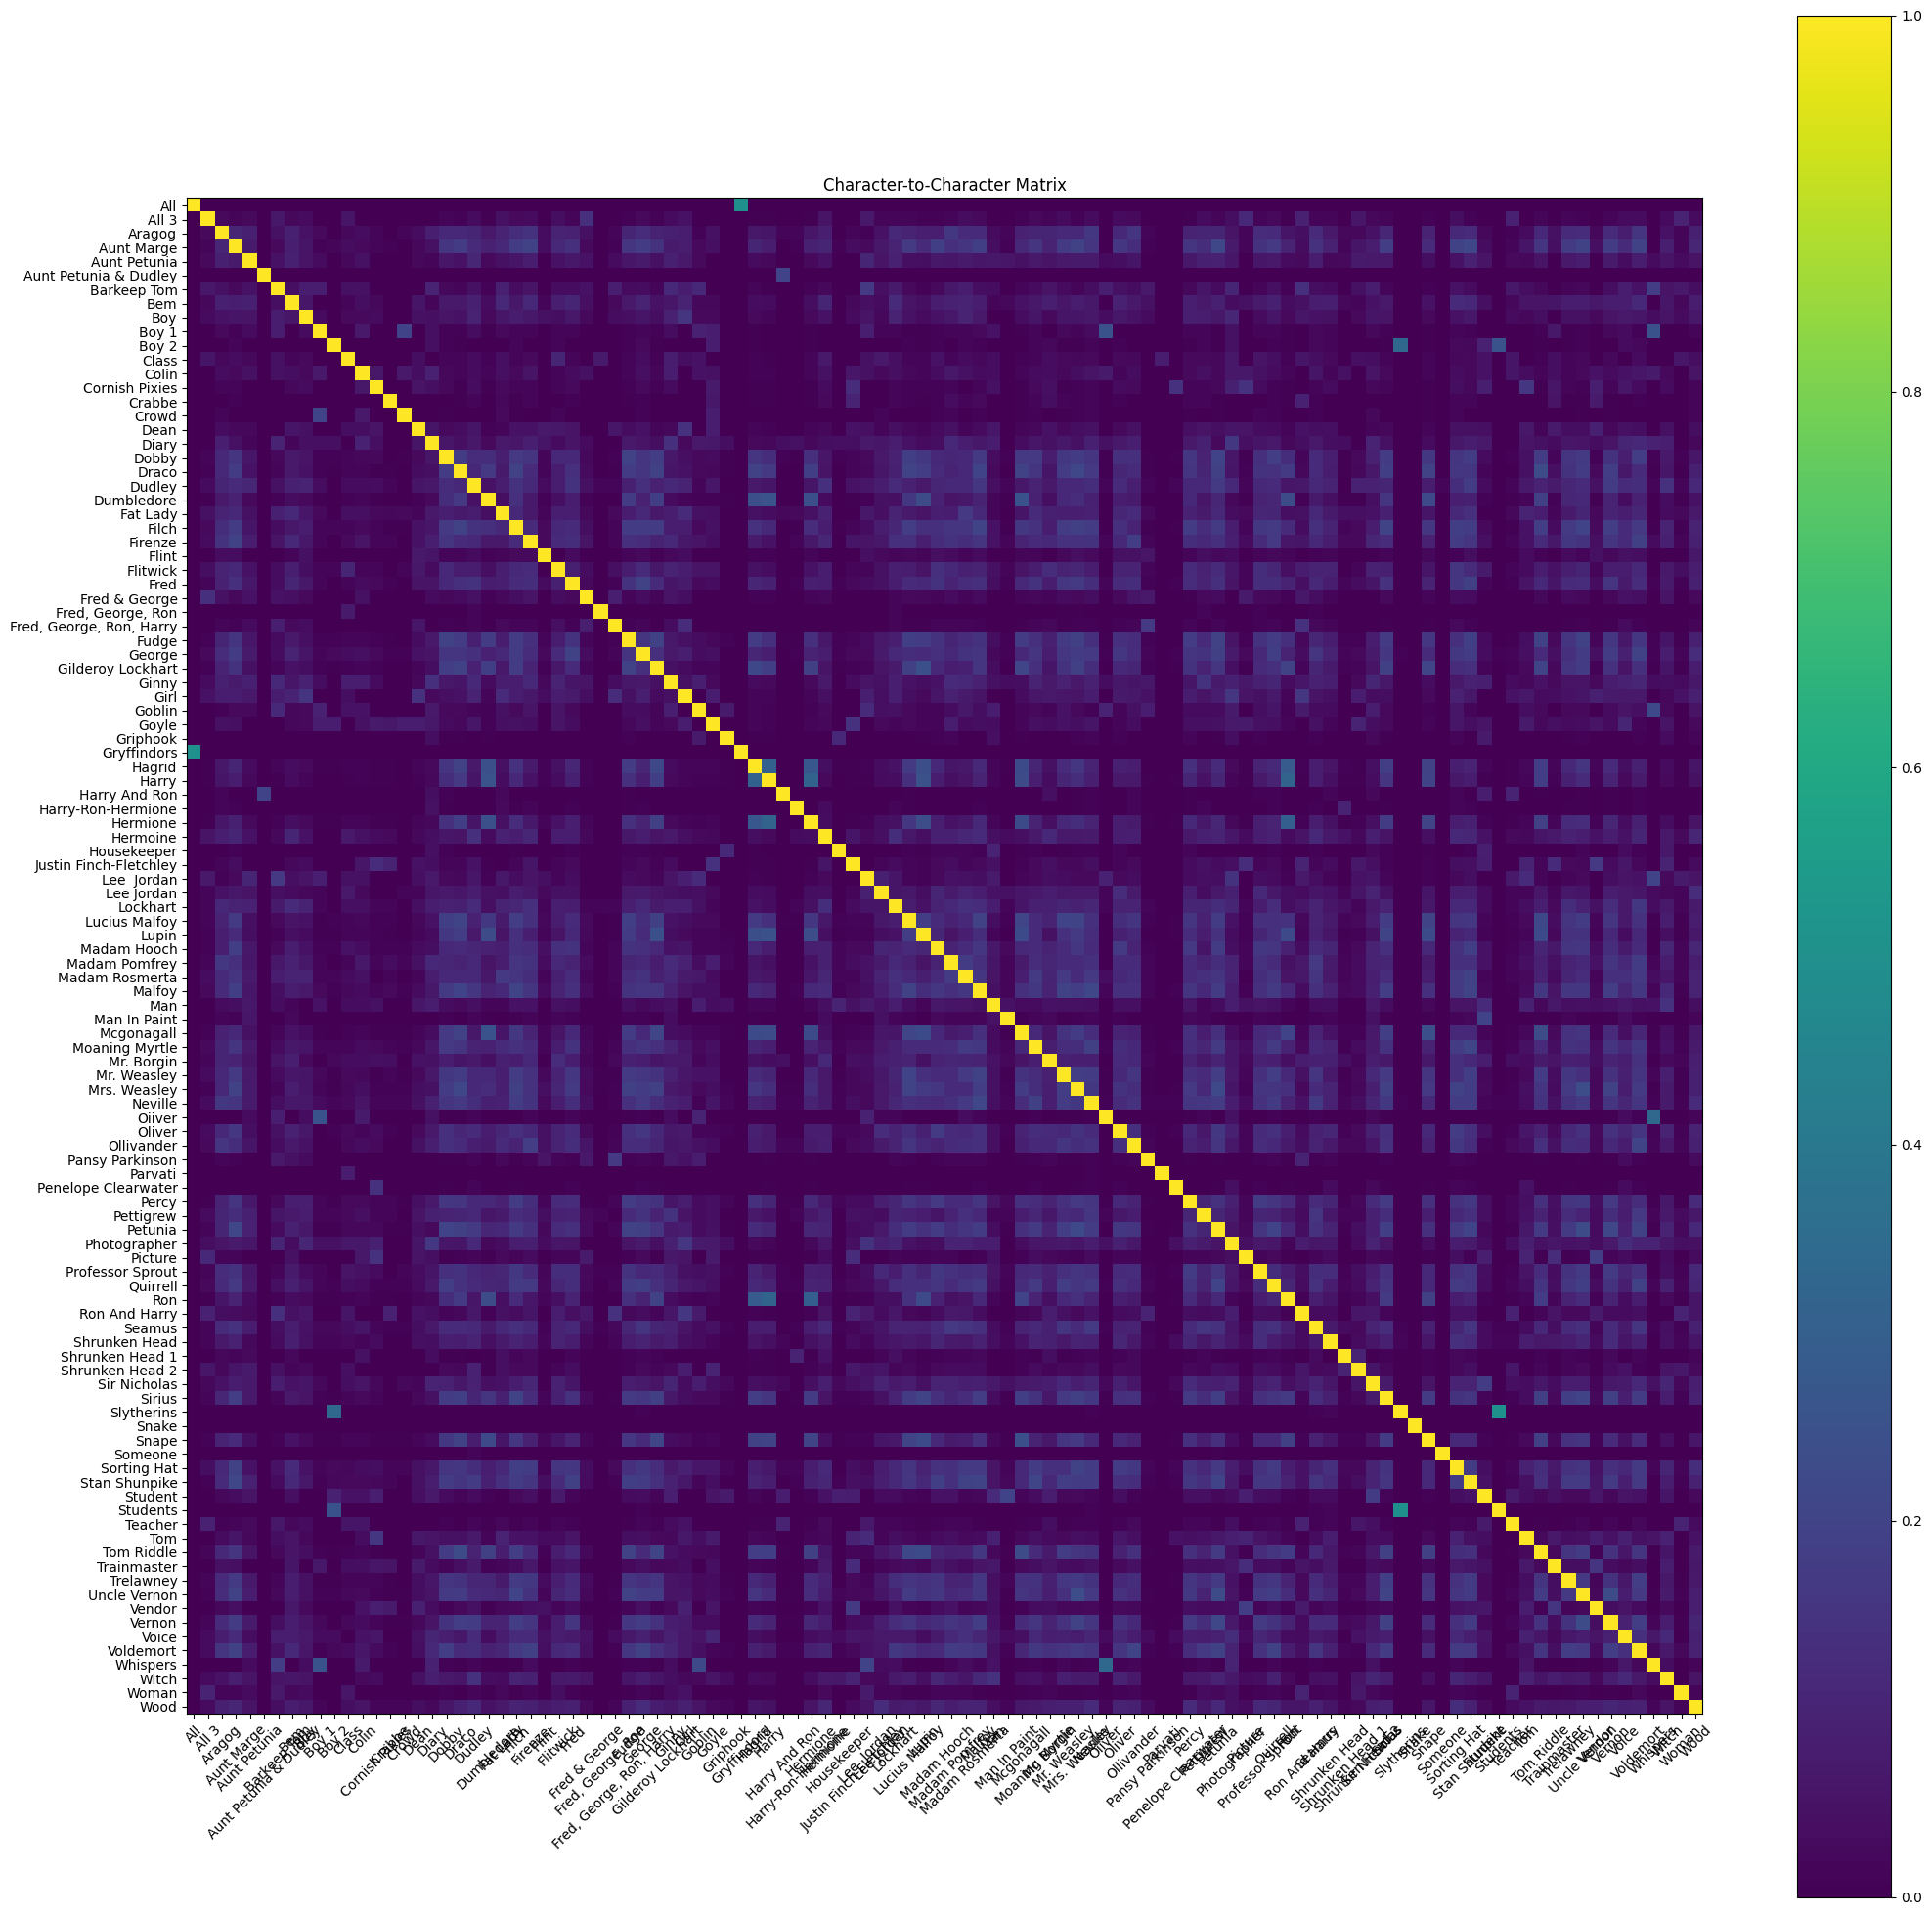

In [231]:
#Plot the matrix
CharacterToCharacterMatrixPlot(combined_sentences['Character'], similarity_df)

In [232]:
#Most 30 common paris
mostCommonPairs(combined_sentences['Character'], similarity_df, 30)

Most Common Pairs:
All and Gryffindors: 0.5 Similarity
Gryffindors and All: 0.5 Similarity
Slytherins and Students: 0.5 Similarity
Students and Slytherins: 0.5 Similarity
Boy 2 and Slytherins: 0.3333333333333333 Similarity
Oiiver and Whispers: 0.3333333333333333 Similarity
Slytherins and Boy 2: 0.3333333333333333 Similarity
Whispers and Oiiver: 0.3333333333333333 Similarity
Harry and Hermione: 0.3199691595990748 Similarity
Hermione and Harry: 0.3199691595990748 Similarity
Harry and Ron: 0.31790123456790126 Similarity
Ron and Harry: 0.31790123456790126 Similarity
Hagrid and Harry: 0.31219903691813805 Similarity
Harry and Hagrid: 0.31219903691813805 Similarity
Hermione and Ron: 0.3002610966057441 Similarity
Ron and Hermione: 0.3002610966057441 Similarity
Hagrid and Ron: 0.28701180744777477 Similarity
Ron and Hagrid: 0.28701180744777477 Similarity
Hagrid and Hermione: 0.2721575649059982 Similarity
Hermione and Hagrid: 0.2721575649059982 Similarity
Dumbledore and Harry: 0.256797583081571 S

In [ ]:
#Character To Character Matrix for the Similarity of each Character By Using the Common Words in the Unique words of each character
similarity_unique_words_df = SimilarityMatrixByCommonWords(combined_sentences['Character'], combined_sentences['words_mentioned_once'])

In [ ]:
#Plot the matrix
CharacterToCharacterMatrixPlot(combined_sentences['Character'], similarity_unique_words_df)

In [ ]:
#Most common pairs
mostCommonPairs(combined_sentences['Character'], similarity_unique_words_df, 30)

In [ ]:
#Character To Character Matrix for the Similarity of each Character By Using the Common Words in the Vocabulary
similarity_df_50_most_vocabulary = SimilarityMatrixByCommonWords(combined_sentences_50_most_vocabulary['Character'], combined_sentences_50_most_vocabulary['vocabulary'])

#Plot the matrix
CharacterToCharacterMatrixPlot(combined_sentences_50_most_vocabulary['Character'], similarity_df_50_most_vocabulary)

In [ ]:
#Most 30 common paris
mostCommonPairs(combined_sentences_50_most_vocabulary['Character'], similarity_df_50_most_vocabulary, 30)

In [ ]:
#Character To Character Matrix for the Similarity of each Character By Using the Common Words in the Unique words of each character
similarity_unique_words_df_50_most_vocabulary = SimilarityMatrixByCommonWords(combined_sentences_50_most_vocabulary['Character'], combined_sentences_50_most_vocabulary['words_mentioned_once'])

#Plot the matrix
CharacterToCharacterMatrixPlot(combined_sentences_50_most_vocabulary['Character'], similarity_unique_words_df_50_most_vocabulary)

In [ ]:
#Plot the matrix
mostCommonPairs(combined_sentences_50_most_vocabulary['Character'], similarity_unique_words_df_50_most_vocabulary, 30)

In [223]:
#10
# load histwords as gensim KeyedVectors
def load_historical_embeddings(year, 
                               path="historical-embeddings/eng-all_sgns/"):
    with open(path + str(year) + "-vocab.pkl", "rb") as f:
        vocab = pickle.load(f)
    
    vectors = np.load(path + str(year) + "-w.npy", mmap_mode="c")
    
    kv = KeyedVectors(vector_size=vectors.shape[1])
    kv.add_vectors(keys=vocab, weights=vectors, extras=None, replace=False)

    return kv

emb_fic = OrderedDict()
fic_path = 'sgns/'
for year in range(1900, 2000, 10):
    emb_fic[year] = load_historical_embeddings(year, path=fic_path)

In [224]:
def histword_similarity(characters, word_lists):
    # Calculate character embeddings by averaging word embeddings
    character_embeddings = [np.mean([emb_fic[1990][word] for word in word_list if word in emb_fic[1990]], axis=0) for word_list in word_lists]
    
    # Create a character-to-character Jaccard similarity matrix
    character_names = characters.tolist()
    
    # Calculate character-to-character cosine similarity
    similarity_matrix = cosine_similarity(character_embeddings)
    
    # Create a character-to-character similarity DataFrame
    histword_similarity_df = pd.DataFrame(similarity_matrix, columns=character_names, index=character_names)
    return histword_similarity_df

histword_similarity_df = histword_similarity(combined_sentences_50_most_vocabulary['Character'], combined_sentences_50_most_vocabulary['vocabulary'])

In [225]:
histword_similarity_df

,Harry,Hermione,Ron,Dumbledore,Hagrid,Lupin,Mcgonagall,Snape,Gilderoy Lockhart,Tom Riddle,...,Firenze,Pettigrew,Lee Jordan,Dudley,Shrunken Head,Lockhart,Madam Rosmerta,Madam Pomfrey,Flitwick,Mr. Borgin
Harry,1.000000,0.951022,0.951034,0.821428,0.963283,0.905630,0.861758,0.874256,0.919464,0.917148,...,0.834372,0.867155,0.322280,0.884997,0.614396,0.555882,0.858904,0.822651,0.752435,0.700453
Hermione,0.951022,1.000000,0.922584,0.873732,0.938291,0.940981,0.881333,0.916941,0.939606,0.930266,...,0.884923,0.848512,0.323014,0.847003,0.539343,0.569732,0.830163,0.808029,0.762417,0.718633
Ron,0.951034,0.922584,1.000000,0.733996,0.948532,0.838315,0.769292,0.804377,0.867196,0.852827,...,0.786687,0.824707,0.302118,0.854729,0.648169,0.491067,0.825986,0.779849,0.753417,0.684930
Dumbledore,0.821428,0.873732,0.733996,1.000000,0.805912,0.924807,0.927837,0.932299,0.875745,0.895590,...,0.818009,0.770039,0.385896,0.702283,0.377910,0.596373,0.706614,0.727943,0.632620,0.629283
Hagrid,0.963283,0.938291,0.948532,0.805912,1.000000,0.896876,0.855438,0.870583,0.915952,0.908144,...,0.836056,0.869626,0.324083,0.895148,0.625970,0.537272,0.850576,0.818471,0.763664,0.718407
Lupin,0.905630,0.940981,0.838315,0.924807,0.896876,1.000000,0.917808,0.948553,0.949269,0.945951,...,0.862667,0.844298,0.305363,0.823366,0.478216,0.592511,0.808343,0.809806,0.729813,0.681320
Mcgonagall,0.861758,0.881333,0.769292,0.927837,0.855438,0.917808,1.000000,0.931804,0.904191,0.922621,...,0.835694,0.786634,0.387438,0.772430,0.499053,0.656295,0.768753,0.754995,0.663422,0.655396
Snape,0.874256,0.916941,0.804377,0.932299,0.870583,0.948553,0.931804,1.000000,0.929765,0.930832,...,0.861693,0.825160,0.336296,0.784475,0.493206,0.634792,0.776437,0.802850,0.714790,0.692580
Gilderoy Lockhart,0.919464,0.939606,0.867196,0.875745,0.915952,0.949269,0.904191,0.929765,1.000000,0.934288,...,0.853988,0.857168,0.330256,0.860158,0.554118,0.616048,0.828021,0.823141,0.772044,0.700126
Tom Riddle,0.917148,0.930266,0.852827,0.895590,0.908144,0.945951,0.922621,0.930832,0.934288,1.000000,...,0.872608,0.854794,0.330083,0.844962,0.533161,0.595331,0.826628,0.806202,0.724308,0.704383


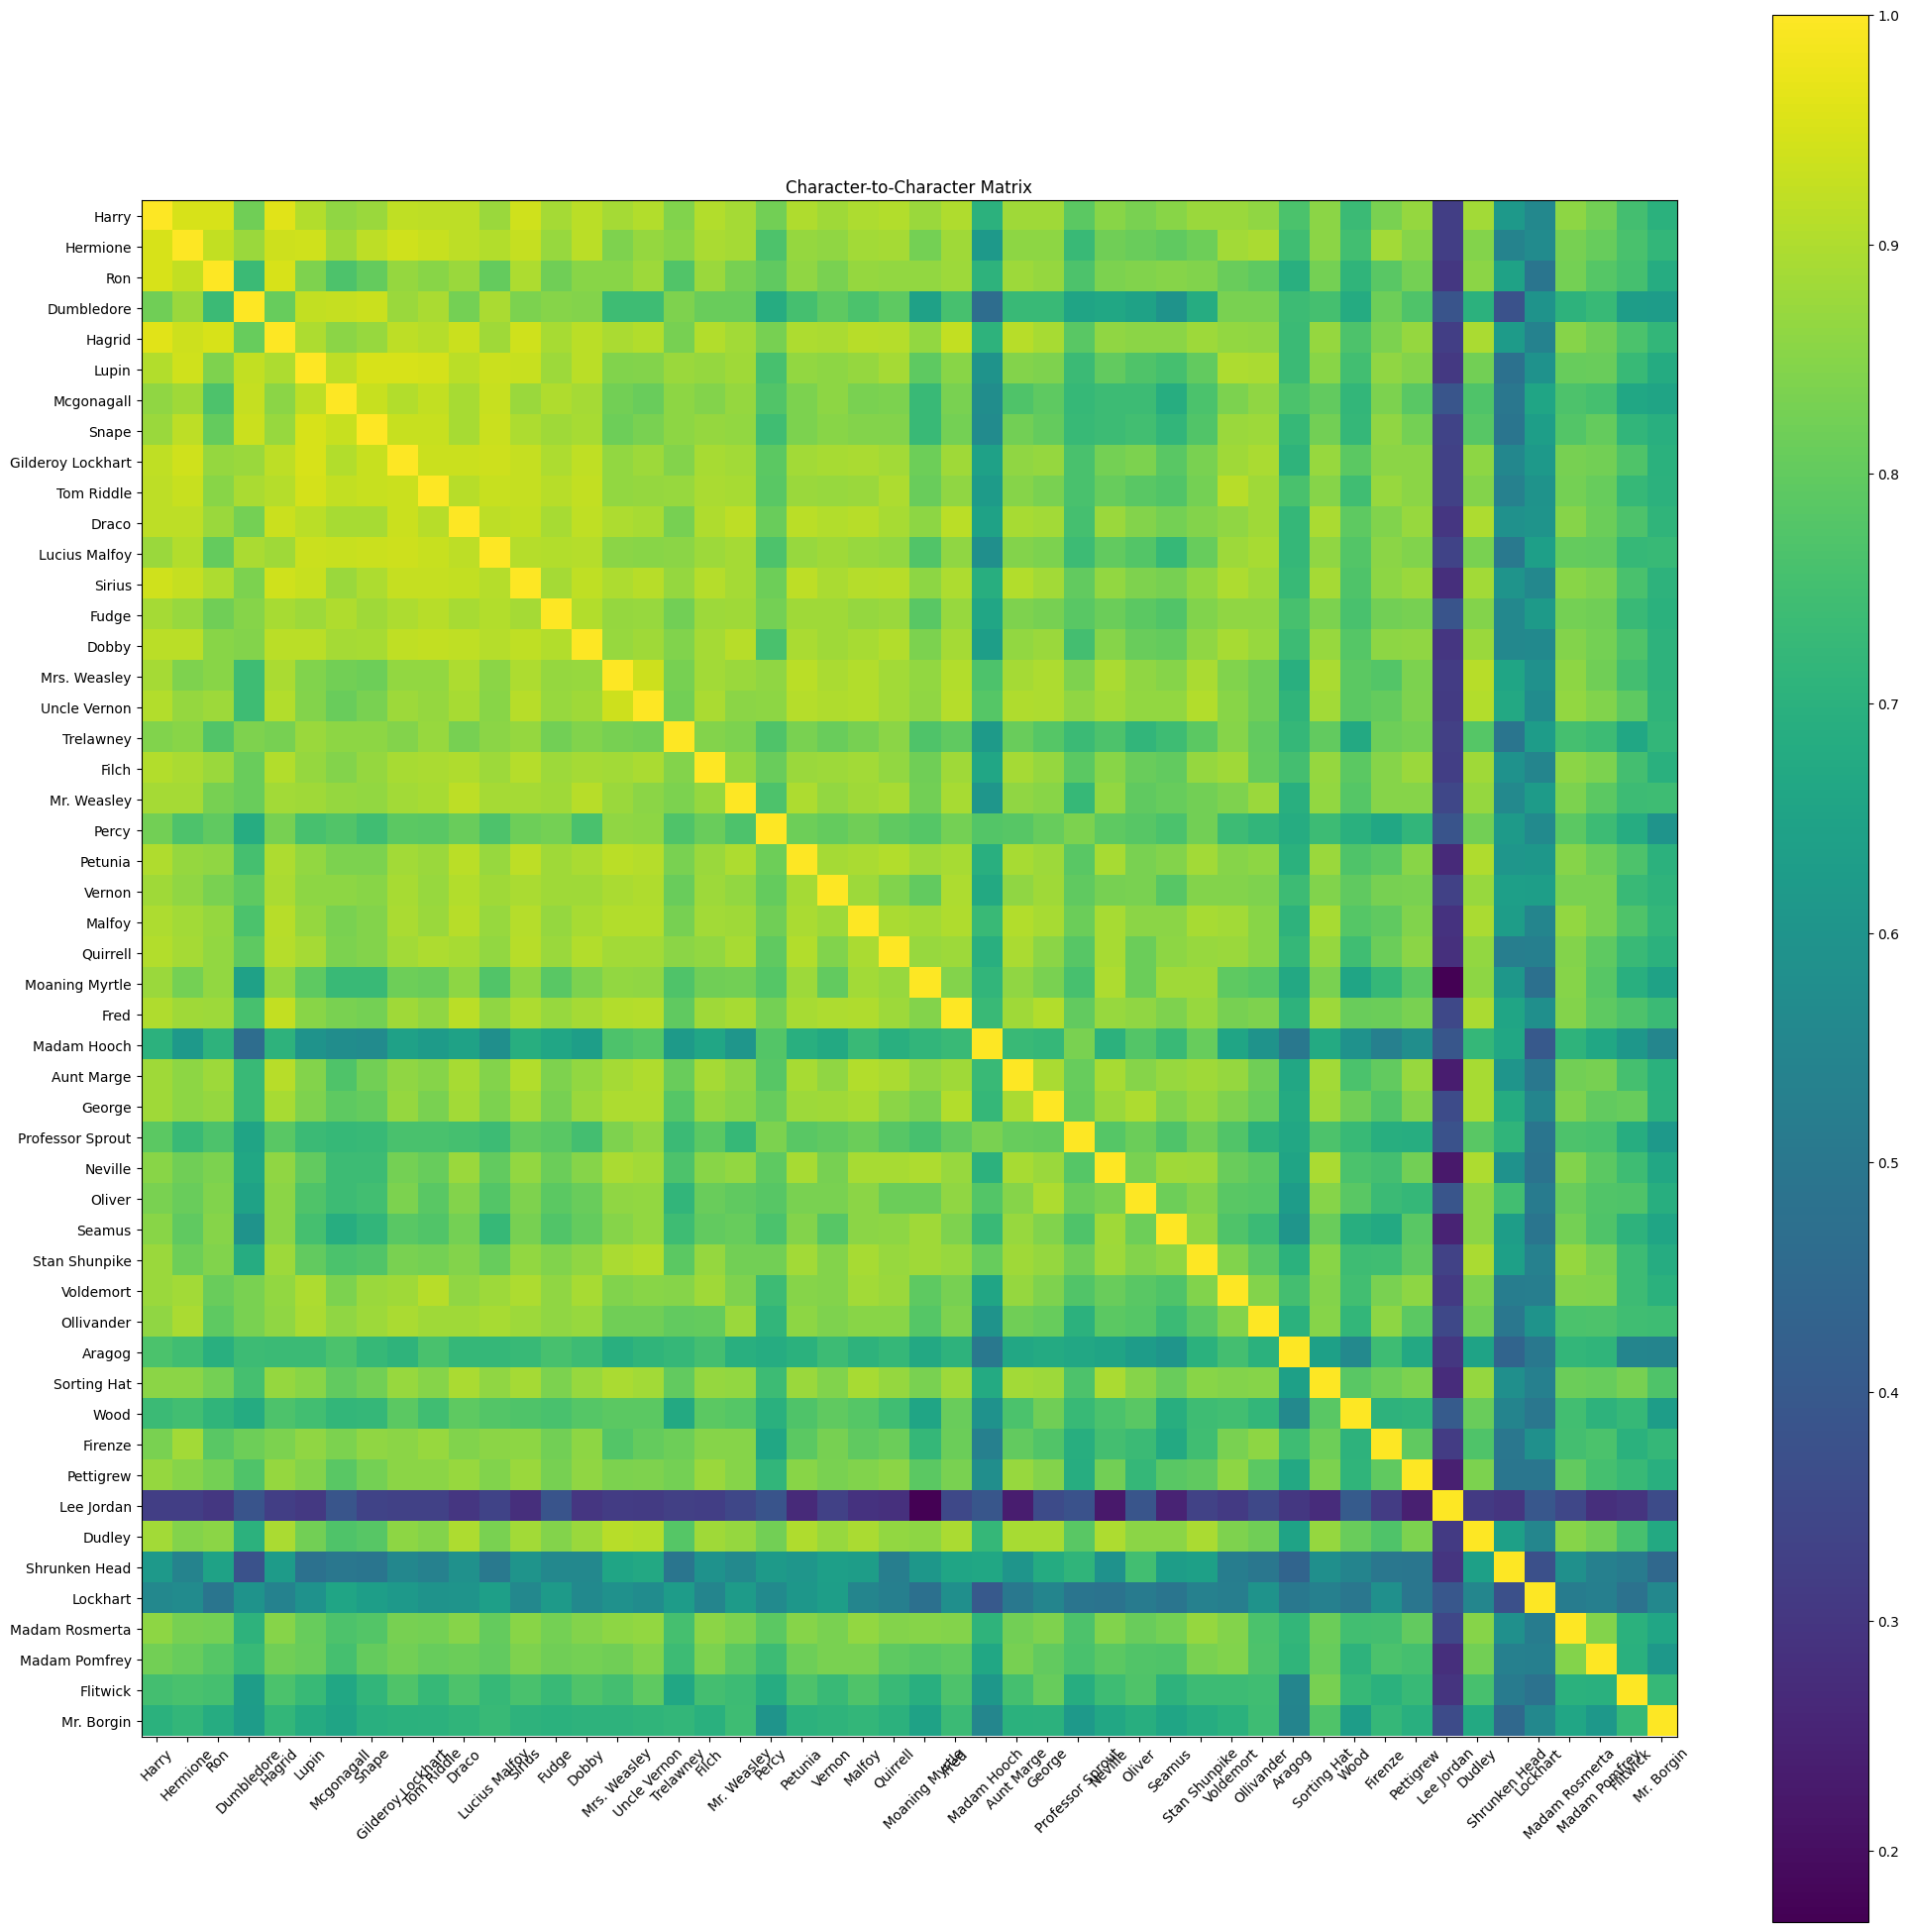

In [226]:
#Plot the matrix
CharacterToCharacterMatrixPlot(combined_sentences_50_most_vocabulary['Character'], histword_similarity_df)